In [12]:
import ima_utils
import sklearn.preprocessing as preproc
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA, NMF, DictionaryLearning, IncrementalPCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Globals
_SHUFFLE = True
_SEED = 0
_LIMITS = True

In [3]:
# Set the paths for image files, labels etc
faces_path = "../data/Faces/"
labels_path = "../data/labels.csv"
names_path = "../data/filenames.txt"

data_set_gray_npy = "data_gray.npy"
data_set_rgb_npy = "data_rgb.npy"
labels_csv_path = "data_labels.csv"

In [4]:
# Get labels as pandas object from labels.csv
labels = ima_utils.get_labels_df(
    labels_path=labels_path, names_path=names_path)

In [5]:
# Limit age
if _LIMITS:
    age_min = 18
    age_max = 80
    labels = labels.loc[(labels.age >= age_min) & (labels.age <= age_max)]

In [6]:
# Put age in bins
age_bin_width_years = 25
ages = labels.age.values//age_bin_width_years  # bin_width fully lived
labels.drop(['age'], axis=1, inplace=True)
labels['age_bin'] = ages

In [7]:
# Open a random image to get dimensions
h, w = ima_utils.get_dimensions_from_an_image(faces_path, 0, as_gray=True)

In [8]:
# Split full data set
train_dataset_idx, test_dataset_idx = train_test_split(labels.index.to_list())

X = np.load(data_set_gray_npy)

data_train, data_test = X[train_dataset_idx], X[test_dataset_idx]
labels_train, labels_test = labels.loc[train_dataset_idx], labels.loc[test_dataset_idx]
labels_train = labels_train.reset_index()
labels_test = labels_test.reset_index()
del X, labels  # to avoid accessing the test set and also to save ram


In [9]:
# Select images to load

n_elements_from_label = 1000
label_to_choose_from = "random"
images_to_load = ima_utils.pick_n_from_label(
    labels_train, n_elements_from_label, label_to_choose_from, shuffle=_SHUFFLE
)


In [10]:

X = data_train[images_to_load, :]


labels_loaded = labels_train.loc[images_to_load]
labels_loaded = labels_loaded.reset_index()

y_age = labels_loaded.age_bin.values
y_race = labels_loaded.race.values
y_gender = labels_loaded.gender.values

C:\Users\user\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


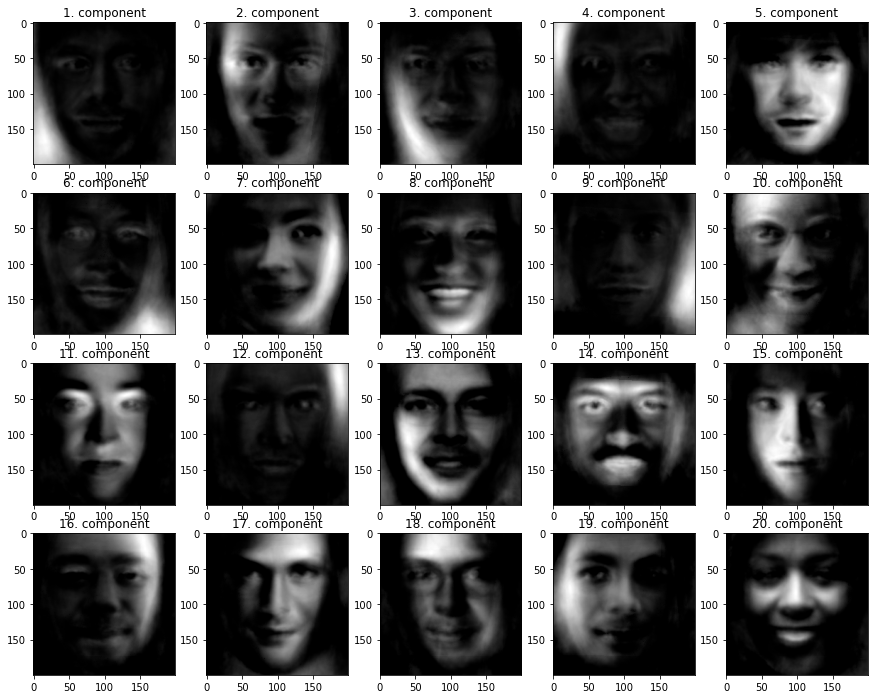

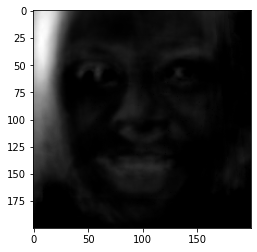

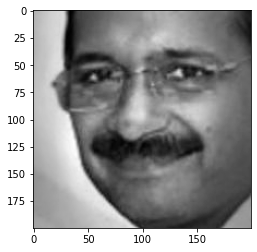

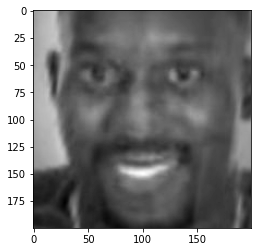

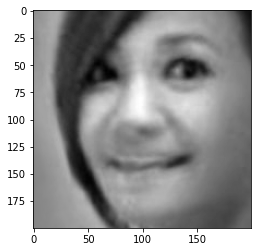

In [13]:
# Check to see the output of the decomposition method 
X_train, X_test = train_test_split(X)

n_components = 20
max_iter = 500

scaler = preproc.StandardScaler(with_mean=False)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

nmf = NMF(n_components=n_components, solver='mu', max_iter=max_iter,
          random_state=_SEED, init='random').fit(X_train_sc)

X_train_nmf = nmf.transform(X_train_sc)
X_test_nmf = nmf.transform(X_test_sc)


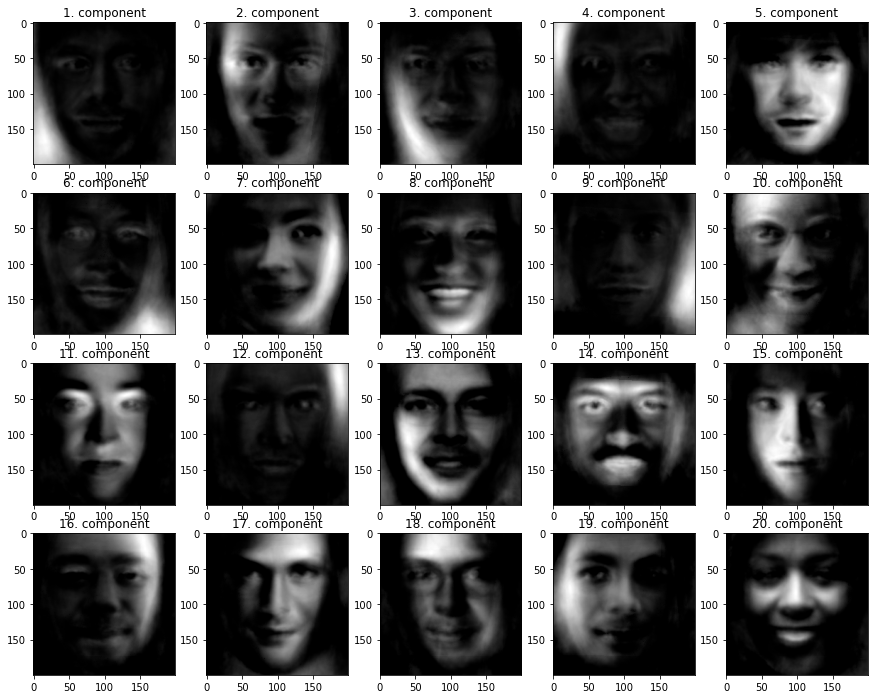

In [14]:

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, (component, ax) in enumerate(zip(nmf.components_[:20], axes.ravel())):
    ax.imshow(component.reshape(h, w), cmap='gray')
    ax.set_title(f"{i+1}. component")
plt.show()


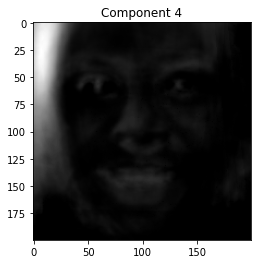

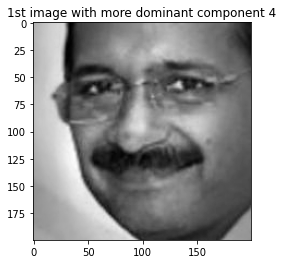

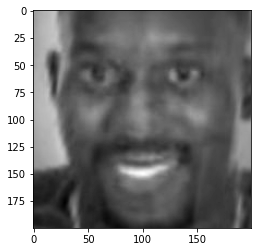

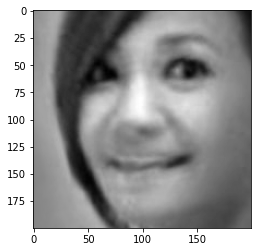

In [16]:

# Look at specific components

specific_component = 4
if specific_component > n_components:
    specific_component = n_components

idx = np.argsort(X_train_nmf[:, (specific_component-1)])
idx = (idx[::-1])
idx = idx[:5]

plt.figure()
plt.title(f"Component {specific_component}")
ima_utils.plot_image(nmf.components_[(specific_component-1)], h, w)
plt.show()
plt.title(f'1st image with more dominant component {specific_component}')
ima_utils.plot_image(X_train_sc[idx[0], :], h, w)
plt.show()
plt.title(f'2nd image with more dominant component {specific_component}')
ima_utils.plot_image(X_train_sc[idx[1], :], h, w)
plt.show()
plt.title(f'3rd image with more dominant component {specific_component}')
ima_utils.plot_image(X_train_sc[idx[2], :], h, w)
plt.show()

In [ ]:
# Try, using the single data set to change the gender of a random image, knowing its gender

C:\Users\user\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


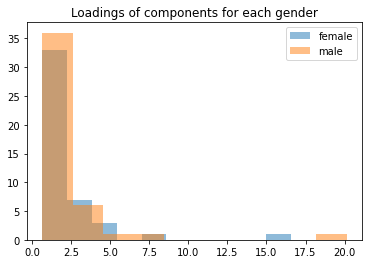

In [18]:
# Train NMF here with 45 components
num_comp = 45

nmf = NMF(n_components=num_comp, random_state=_SEED, init='random',max_iter=max_iter).fit(X)

X_nmf = nmf.transform(X)

female_scores = X_nmf[labels_loaded.loc[labels_loaded.gender==1].index.to_list(),:]
male_scores = X_nmf[labels_loaded.loc[labels_loaded.gender==0].index.to_list(),:]

f2m_ratio = female_scores.mean(0)/male_scores.mean(0) #


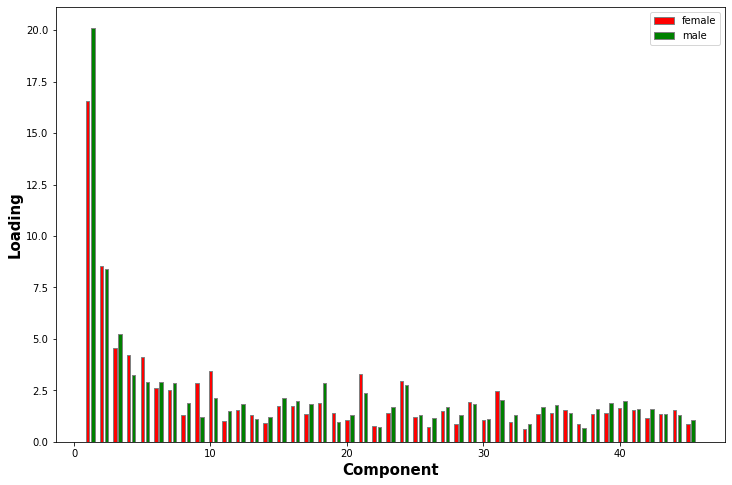

In [37]:
# From https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
IT = [12, 30, 1, 8, 22]
ECE = [28, 6, 16, 5, 10]
CSE = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
br1 = np.arange(num_comp)+1
br2 = [x + 1.5*barWidth for x in br1]
 
# Make the plot
plt.bar(br1, female_scores.mean(0), color ='r', width = barWidth,
        edgecolor ='grey', label ='female')
plt.bar(br2, male_scores.mean(0), color ='g', width = barWidth,
        edgecolor ='grey', label ='male')

# Adding Xticks
plt.xlabel('Component', fontweight ='bold', fontsize = 15)
plt.ylabel('Loading', fontweight ='bold', fontsize = 15)

 
plt.legend()
plt.show()

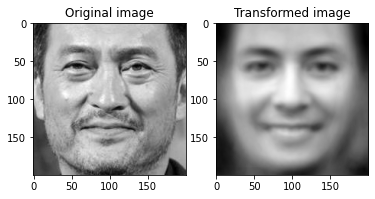

In [39]:
test_number = 5

X_test_male = X[labels_loaded.loc[labels_loaded.gender==0].index.to_list()[test_number],:]
X_test_male_nmf = nmf.transform(X_test_male.reshape(1,-1))
X_test_male_reconstr = (f2m_ratio*X_test_male_nmf).dot(nmf.components_)


plt.subplot(1,2,1)
plt.title(f'Original image')
ima_utils.plot_image(X_test_male,h,w)

plt.subplot(1,2,2)
plt.title(f'Transformed image')
ima_utils.plot_image(X_test_male_reconstr,h,w)